In [15]:
%matplotlib inline
import numpy as np
from math import exp
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # necessary for 3D plotting
import matplotlib.cm as cm
from pylab import figure, plot, show, grid, axis, xlabel, ylabel, title, hold, draw
import scipy.stats as stats
import seaborn as sns
from sympy import plot_implicit
sns.set_style('darkgrid')
from sklearn.metrics import mean_squared_error
from compound_poisson import box_muller, mvn, func, IncrementsCompoundPoissonTwoDim


#The Wiener process parameters.
C = np.array([[2, 1], [1, 1]])

# Total time.
T = 1

# Number of steps.
N = 1000

# Time step size
dt = T/N

#index activity
index = [1.2, 1.8]

def BrownianIncrements(C, N):
    """Brownian increments"""
    L = np.linalg.cholesky(C)
    DB = np.zeros((2, N))
    for j in range(N):
        DB[0, j] = np.random.normal(0, 1) / np.sqrt(N)
        DB[1, j] = np.random.normal(0, 1) / np.sqrt(N)
        DB[:, j] = L @ DB[:, j]
    # B = np.cumsum(DB, axis = 1)
    return DB
DB_T = BrownianIncrements(C, N)

def phi_hat(u, DX):
    """Empirical characteristic function"""
    N = len(DX[0, :])
    dotproducts = np.zeros(N)
    for j in range(N):
        dotproducts[j] = np.inner(u, DX[:, j])
    return np.mean(np.exp(np.complex(0,1) * dotproducts))

#2-dim stable process increments
def StableIncrements(N):
    DX = np.zeros((N,2))
    Gamma = np.random.uniform(-0.5 * np.pi, 0.5 * np.pi, N)
    W = np.random.exponential(1, N)
    DX = [pow(dt, 1 / a) * (np.sin(a * Gamma))/ pow(np.cos(Gamma),1 / a)* \
                 pow((np.cos((1 - a) * Gamma)) / W, (1 - a) / a) for a in index]
    return DX
stable = StableIncrements(N)

#2-dim jump diffusion increments
def two_dim_jump_diffusion(ts, N, stable, DB_T):
    DX = np.zeros((2, N))
    DB_T = BrownianIncrements(C, N)
    stable = StableIncrements(N)
    DX = [sum(x) for x in zip(stable, DB_T)]
    DX_I = np.asarray(DX)
    return DX_I
DX_IA = two_dim_jump_diffusion(np.linspace(0, 1, N), N, stable, DB_T)

#parameters for the spectral estimator
M = 4.229

r = 1.8

U_prime = (np.sqrt((r-1)*N*np.log(N)))/np.sqrt(M)
u_N = np.array([U_prime, U_prime])
u_N_tilde = np.array([U_prime, - U_prime])

#spectral estimator for covariance
C_hat = (N / (2 * u_N[0]**2)) * ((np.log(np.abs(phi_hat(u_N_tilde, DX_IA))) -
    np.log(np.abs(phi_hat(u_N, DX_IA)))))

In [16]:
# Monte carlo simulation
n = 1000
ts = np.linspace(0, 1, N)
C_hat = np.zeros(n)
for iteration in range(n):
    DX = two_dim_jump_diffusion(ts, N, stable, DB_T)
    C_hat[iteration] = (N / (2 * u_N[0]**2)) * ((np.log(np.abs(phi_hat(u_N_tilde, DX))) - np.log(np.abs(phi_hat(u_N, DX)))))

In [11]:
vec = np.ones(n)
mean = mean_squared_error(C_hat, vec)
rmse = np.sqrt(mean)

/Users/Kcantor/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


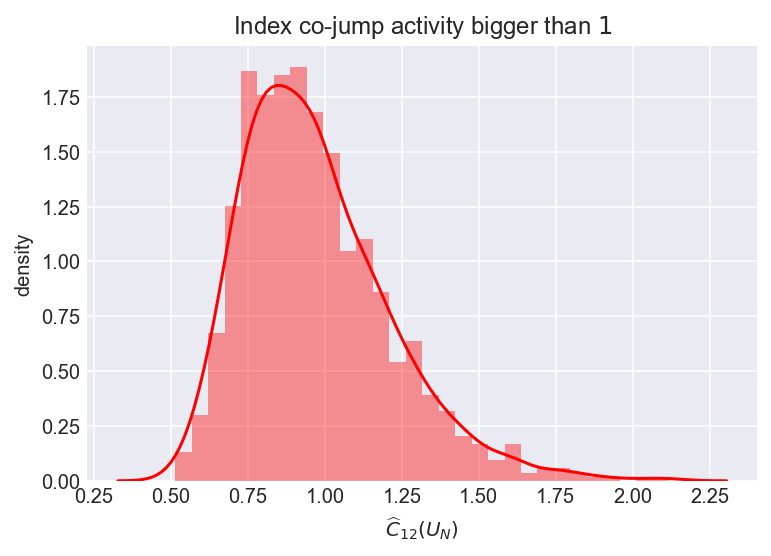

In [12]:
%config InlineBackend.figure_format = 'retina'

plt.savefig("histFA.png")
sns.distplot(C_hat, norm_hist = True, bins = 30, color = 'r')

title('Index co-jump activity bigger than $1$')
xlabel('$\widehat{C}_{12}({U}_{N})$')
ylabel('density')
plt.show()


In [13]:
#  MC estimation for C_hat against different choices of our parameter U_N for r  = > 1 (infinite variation of jumps)

import time
start_time = time.time()

#different choices of N
N = [x for x in range(1000, 10100, 1000)]

r = 1.8

# preallocate the results in emply list
C_hat = [] 

#Monte Carlo loop
n = 1000
for j in N:
    for iter in range(n):
        DX = two_dim_jump_diffusion(np.linspace(0, 1, j), j, stable, DB_T)
        U_prime = (np.sqrt((r-1)*j*np.log(j)))/np.sqrt(M)
        u_N = np.array([U_prime, U_prime])
        u_N_tilde = np.array([U_prime, - U_prime])
        C_hat.append((j / (2 * u_N[0]**2)) * ((np.log(np.abs(phi_hat(u_N_tilde, DX))) - np.log(np.abs(phi_hat(u_N, DX))))))

#split the data of C_hat in N arrays of size (1, n) each, i.e. for each choise of N print C_hat for n times MC.
C_hat_data = [C_hat[x : x + n] for x in range(0, len(C_hat), n)]  

elapsed_time = time.time() - start_time 

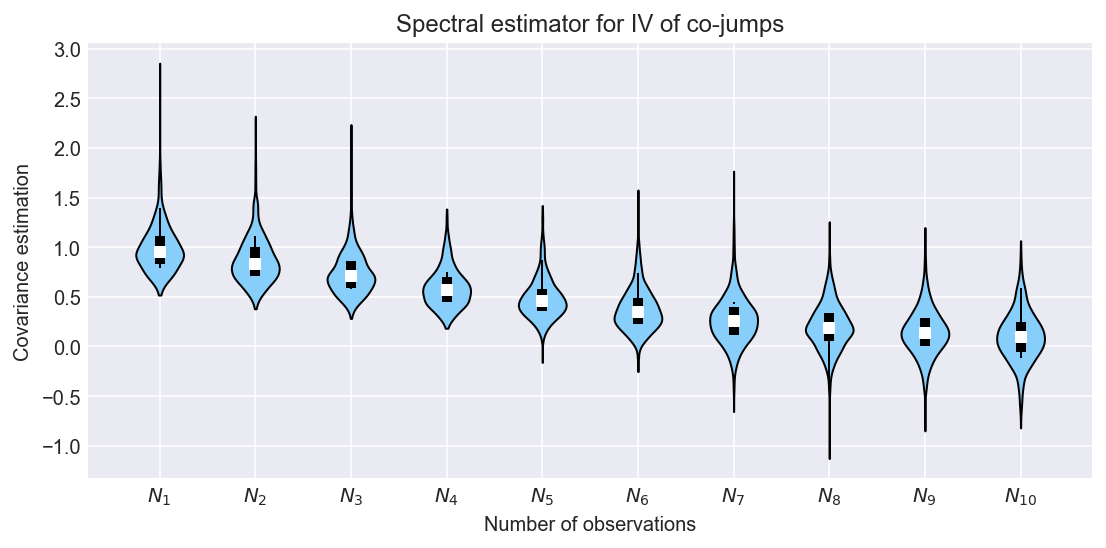

In [6]:
#violin plots

%config InlineBackend.figure_format = 'retina'

def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(x, labels):
    x.get_xaxis().set_tick_params(direction='out')
    x.xaxis.set_ticks_position('bottom')
    x.set_xticks(np.arange(1, len(labels) + 1))
    x.set_xticklabels(labels)
    x.set_xlim(0.25, len(labels) + 0.75)
    x.set_xlabel('Number of observations')

fig, (x) = plt.subplots(nrows=1, ncols=1, figsize=(9, 4), sharey = True)
x.set_title('Spectral estimator for IV of co-jumps')
parts = x.violinplot(
        C_hat_data, showmeans = False, showmedians = False,
        showextrema = False)

for pc in parts['bodies']:
    pc.set_facecolor('lightskyblue')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

quartile1, medians, quartile3 = np.percentile(C_hat_data, [25, 50, 75], axis=1)

whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(C_hat_data, quartile1, quartile3)])
whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
x.scatter(inds, medians, marker = 's', color = 'white', s = 30, zorder = 3)
x.vlines(inds, quartile1, quartile3, color = 'k', linestyle = '-', lw = 5)
x.vlines(inds, whiskersMin, whiskersMax, color = 'k', linestyle = '-', lw = 1)

# set style for the axes
labels = ['$N_{1}$', '$N_{2}$', '$N_{3}$', '$N_{4}$', '$N_{5}$', '$N_{6}$', '$N_{7}$', '$N_{8}$', '$N_{9}$', '$N_{10}$']
ylabel('Covariance estimation')
set_axis_style(x, labels)
plt.show()


In [8]:
#rmse for different choises of N

N = [x for x in range(1000, 10100, 1000)]
mse = []
vec = np.ones(n)
for i in range(len(N)):
    mean = mean_squared_error(C_hat_data[i], vec)
    mse.append(mean)
rmse = np.sqrt(mse)